# Masked Autoencoders

Convolutional neural networks (CNNs) have been the dominant architecture for computer vision tasks for many years.
Recently, however, with the introduction of vision transformers (ViTs), CNNs are being replaced in many areas.
ViTs are equipped with the _self-attention mechanism_ (which we will learn more about in the practical), allowing them to model global relationships within an image more effectively.

_Self-supervised learning (SSL)_ provides a viable alternative to supervised learning by allowing a model to learn useful representations from _unlabeled data_, removing the need for costly annotations (such as in the medical domain) and often leading to better representations than those learned through supervised learning.
In the case of masked autoencoders (MAE), the model is trained to reconstruct missing portions of an image.


In this practical, you'll learn how to implement a vision transformer, and use it as the backbone to implement a masked autoencoder (MAE)—one of the most popular self-supervised learning (SSL) methods.

Since MAE mainly uses vision transformers (ViT) as its backbone, we'll begin by building a simple vision transformer and then proceed to implement MAE.

Useful resources:
1. [Masked Autoencoders Are Scalable Vision Learners](https://arxiv.org/abs/2111.06377)
2. [An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale](https://arxiv.org/abs/2010.11929)


## Import packages

In [5]:
import datetime
import time
from functools import partial
import os
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torchvision.transforms as transforms
import torchvision
from torchvision.transforms import InterpolationMode

data_path = './data/CIFAR10'
output_dir = './output_dir/tmp'
device = 'cuda:0'  # suggestion: change this to cpu for debugging to avoid resource limitations in Colab.

## Patchifying an image


Vision transformers process images as a sequence of patches, much like how traditional transformers in natural language processing handle sequences of words.
In this case, instead of words, the model works with image patches. These patches are essentially non-overlapping $p \times p$ grids extracted from the original image.

Below we visulize what happens when an image is converted to patches, to get a better understanding of it.

In [6]:
def patchify(patch_size: int, imgs: torch.Tensor, flatten_channels: bool =True):
    """
        This function receives a batch of images and transform each image into patches.
        - patch_size: size of the square patches into which the input image is divided
        - imgs: (N, 3, H, W)
        - x: (N, L, patch_size**2 *3)
    """
    p = patch_size
    assert imgs.shape[2] == imgs.shape[3] and imgs.shape[2] % p == 0

    h = w = imgs.shape[2] // p
    x = imgs.reshape(shape=(imgs.shape[0], 3, h, p, w, p))
    x = torch.einsum('nchpwq->nhwpqc', x)
    if flatten_channels:
        x = x.reshape(shape=(imgs.shape[0], h * w, p**2 * 3))  # (N, L, p**2 *3), for model training
    else:
        x = x.reshape(shape=(imgs.shape[0], h * w, p, p, 3))  # (N, L, p, p, 3), for visualization
    return x

For illustration, we use a large patch size to better understand the mechanism, but in ViT a smaller patch size is typically used.




100%|██████████| 170M/170M [00:12<00:00, 13.1MB/s] 


Extracting ./data/CIFAR10/cifar-10-python.tar.gz to ./data/CIFAR10


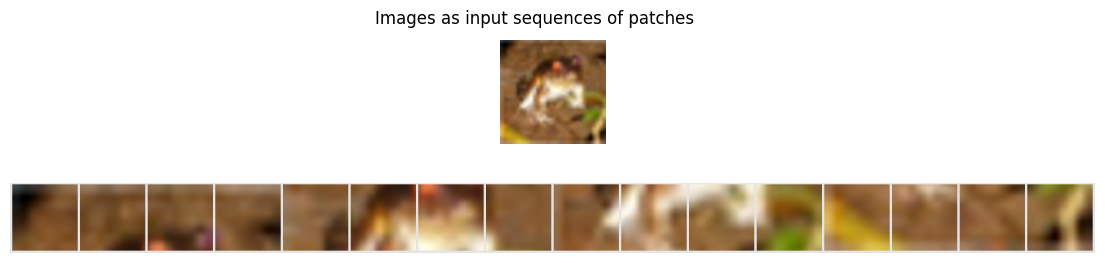

In [3]:
img_size = 224
psize = 56  # divide the img into patches of this size (you can play aroud with different numbers)
assert img_size % psize == 0, 'img size should be divisble by patch size!'

dataset_test = torchvision.datasets.CIFAR10(root=data_path, train=True, transform=None, download=True)
orig_img, label = dataset_test[0]
orig_img = orig_img.resize((img_size, img_size))

img = torch.Tensor(np.array(orig_img))  # (224, 224, 3)
# make it like a mini-batch of size B=1 - (1, 224, 224, 3), since the function expects a batch
img = img.unsqueeze(dim=0)
# use einsum for permutation of tensor dims (B, H, W, C) --> (B, C, H, W), as the function expects
img = torch.einsum('nhwc->nchw', img)
patches = patchify(patch_size=psize, imgs=img, flatten_channels=False)
patches = patches.squeeze(dim=0)  # extract the single img

# make a grid and visualize
img_grid = torchvision.utils.make_grid(tensor=torch.einsum('lpqc -> lcpq', patches), nrow=patches.shape[0], normalize=True, pad_value=0.9)
img_grid = torch.einsum('chw -> hwc', img_grid)  # imshow expects shape (H, W, C)

fig, ax = plt.subplots(2, 1, figsize=(14, 3))
fig.suptitle("Images as input sequences of patches")

# display the image
ax[0].imshow(orig_img)
ax[1].imshow(img_grid)

ax[0].axis('off')
ax[1].axis('off')

plt.show()
plt.close()

## Vision Transformer (ViT)

### Patch Embedding

To enhance the versatility of ViT representations, the patchification process in Vision Transformers (ViTs) is typically implemented using a trainable module.
This module learns to map image patches to "tokens," which are vector representations of each patch.

This mapping is achieved through a convolutional operation that transforms each patch of size ($c \times p \times p$) into a token of shape (`embed_dim`$\times 1$).
Here, `embed_dim` represents the dimension of each token, with larger values allowing for more expressive representations of each patch.

Below, we implement this module

In [7]:
class PatchEmbed(nn.Module):
    """ Image to Patch Embedding
    """
    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=384):
        super().__init__()
        num_patches = (img_size // patch_size) * (img_size // patch_size)
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = num_patches
        self.embed_dim = embed_dim

        # convert patches to tokens in a learnable way
        # for simplicity we use stride=patch_size so the patches are non-overlapping
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size, bias=True)

    def forward(self, x):
        """
        TODO: Implement operation to convert patches to tokens
            - x: a batch of images with shape (B, C, H, W)
            - output: a batch of tokens, representing image patches with shape (B, L, D),
            where L is the number of tokens (sequence length), and D is embed_dim
        """
        B, C, H, W = x.shape
        assert H == self.img_size and W == self.img_size, "Input resolution must match img_size"
        x = self.proj(x)
        x = x.flatten(2).transpose(1, 2)
        return x






# test the implementation of patch embeddings
bsize, in_channels, img_size = 16, 3, 224
psize = 16  # patch_size
embed_dim = 384
inp = torch.randn(size=(bsize, in_channels, img_size, img_size))  # a batch of images with size (B, C, H, W)
embedder = PatchEmbed(img_size=img_size, patch_size=psize, in_chans=in_channels, embed_dim=embed_dim)
out = embedder(inp)
n_patches = 196  # (224 / 16) ** 2
assert embedder.num_patches == n_patches, f'Number of patches {embedder.num_patches} does not meet the expected value!'
assert out.shape == (bsize, n_patches, embed_dim), f'The embedding shape {out.shape} does not match the expected value!'

### Multi-Head Attention

The attention mechanism is the key part of transformers that helps the model focus on different parts of the input when making predictions. Think of it like reading a sentence: to understand a particular word, you look at the other words around it to get the full meaning. Similarly, attention helps the model understand the context better by determining which words (or tokens) are more relevant.

To achieve this, the model uses a specific method called *dot-product attention*.
Essentially, attention can be thought of as a way to map a query to a set of key-value pairs.
This method involves three components: query $q$, key $k$, and value $v$, each representing a token.

In practice, we calculate the attention for a set of queries, keys, and values at once by arranging them into a matrix $Q$, $K$, and $V$ respectively.
When $Q$, $K$, and $V$ are coming from the same set of tokens, it is called "self-attention".


To enhance the versatility of the representations, tokens are first transformed using linear transformations.
\begin{equation*}
Q = QW^Q, \quad K = KW^K, \quad V = VW^V
\end{equation*}
where Here, $W^Q$, $W^K$, and $W^V$ are learnable projections matrices that linearly transform $d$-dimensional tokens (to the same dimension $d$).
Following this transformation, attention can be computed on the set of transformed matrices:
\begin{equation*}
\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d}}\right)V
\end{equation*}
The output of $\text{softmax}\left(\frac{QK^T}{\sqrt{d}}\right)$ is basically an $N \times N$ attention matrix A (for $N$ tokens) where each entry $A_{ij}$ denotes the _compatibility_ between token $q_i$ and $k_j$.

As can be seen, this operation essentially calculates the weighted sum of the values $V$, where the weight assigned to each value is determined by the compatibility of the queries $Q$ with the corresponding keys $K$.
This allows the model to capture long-range relationships within an image, enabling the model to effectively integrate information across different parts of the image.


In practice, however, a single attention head may be limited in its capacity to capture diverse semantic meanings within an image.
To overcome this, the Transformer introduces _multi-head attention_, where multiple "attention heads" are used in parallel to calculate attention in different representation subspaces.

Let $h$ denote the number of heads. Instead of performing a single attention function with $d$-dimensional keys, values and query tokens are divided into smaller $d_h$-dimensional tokens, where $d_h \times h = d$.
We denote the resuling matrices for each $\text{head}_i$ as $Q_i$, $K_i$, and $V_i$.

Now the attention is computed for each subspace individually (each resulting in its own attention matrix $A_i$):
\begin{equation*}
\text{head}_i = \text{Attention}(Q_i, K_i, V_i) = \text{softmax}\left(\frac{Q_iK_i^T}{\sqrt{d_h}}\right)V_i
\end{equation*}
Finally, the outputs from multuple heads are concatenated together and integrated through a linear transformation with $W^O$.

\begin{equation*}
\text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1, \ldots, \text{head}_h) W^O
\end{equation*}


Below, we implement the attention mechanism.

In [ ]:
class Attention(nn.Module):
    def __init__(self, dim, num_heads):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5  # helps with the gradients, read more here: https://arxiv.org/abs/1706.03762

        # in practice it is common to use a single linear layer to obtain q, k, v projections
        self.qkv = nn.Linear(dim, dim * 3, bias=True)  # W^Q, W^K, W^V
        self.proj = nn.Linear(dim, dim)  # W^O

    def forward(self, x):
        """
            TODO: implement multi-head self-attention.
        """
        B, N, C = x.shape
        head_dim = C // self.num_heads
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        out = attn @ v
        out = out.transpose(1, 2).reshape(B, N, C)
        out = self.proj(out)
        return out, attn  # out: transformed tokens, attn: attention scores



# test the implementation of multi-head self-attention
bsize, n_tokens = 16, 196  # batch size: 16, num of tokens per image: 196
dim, num_heads = 384, 6

inp = torch.randn(size=(bsize, n_tokens, dim))
multi_head_attention = Attention(dim=dim, num_heads=num_heads)
out, attn = multi_head_attention(inp)

assert out.shape == (bsize, n_tokens, dim), f'Output shape {out.shape} does not match the expected value!'
assert attn.shape == (bsize, num_heads, n_tokens, n_tokens), f'Attention matrix shape {attn.shape} does not match the expected value!'

### MLP layers
Transformers also use MLP layers after the attention mechanism. An MLP generally consists of two linear transformations with a non-linear activation function in between.
Unlike attention, which handles interactions between tokens, the MLP layer transforms each token independently, enhancing its expressiveness.
This is critical to make tokens expressive enough and to enable the model to learn diverse attention patterns (read more [here](https://arxiv.org/abs/2103.03404) if you are interested)



Below, we implement this layer.

In [ ]:
class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features):
        super().__init__()
        out_features = in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, out_features)

    def forward(self, x):
        """
            TODO: implement the forward function of MLP: two linear operation
            with a non-linearity in between.
        """
        x = self.fc1(x)
+        x = self.act(x)
+        x = self.fc2(x)
+        return x



# test MLP implementation
bsize, n_tokens = 16, 196
dim = 384
hidden_dim = 4 * dim  # feature dim is increased by fc1 and decreased back to original dim by fc2

inp = torch.randn(size=(bsize, n_tokens, dim))
mlp_module = Mlp(in_features=dim, hidden_features=hidden_dim)
out = mlp_module(inp)

assert out.shape == (bsize, n_tokens, dim), f'Output shape {out.shape} does not match the expected value!'

### Block
Now that we have implemented the Attention and MLP modules, we can move on to implementing the blocks of the Vision Transformer (provided below).
Each block consists of an Attention module followed by an MLP module, both equipped with residual connections.
Layer normalization is applied before each module to stabalize training and improve performance.

In [1]:
class Block(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4.):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = Attention(dim, num_heads=num_heads)
        self.norm2 = nn.LayerNorm(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim)

    def forward(self, x, return_attention=False):
        y, attn = self.attn(self.norm1(x))
        x = x + y
        x = x + self.mlp(self.norm2(x))
        if return_attention:
            return x, attn
        return x

NameError: name 'nn' is not defined

## Masked autoencoder

The primary goal of MAE is to learn meaningful representations from unlabelled data by reconstructing the the signal its partial observation.
This is achieved using two asymmetric networks: an **encoder** ViT that maps the observed portion of the image to a latent representation, and a lightweight **decoder** ViT, which reconstructs the original signal from this latent representation.

First, an image is **masked** to obtain a small portion of the patches, with the masking ratio typically set to a high value (e.g. 75%).
This approach makes the reconstruction task more challenging for the network, which is crucial for learning more meaningful representations.

The encoder processes only the visible (unmasked) patches and generates latent representations for those patches.
More specifically, as with a standard ViT, the encoder projects patches using a linear transformation to create tokens, adds positional embeddings, and processes the resulting sequence through a series of encoder transformer blocks.

The decoder receives the full set of tokens, including both the encoded visible patches and __mask tokens__.
Each mask token is a shared, learned vector that indicates the presence of a missing patch to be predicted by the decoder.
Positional embeddings are added for all tokens, and the sequence is passed through a series of decoder transformer blocks.
Finally, the decoder linearly projects the tokens back to predict patch pixels.

The final loss is computed as the mean squared error (MSE) between the reconstructed and original image patches in the pixel space, and is only computed for the masked patches.

Below we implement MAE.

In [ ]:
def random_masking(x, mask_ratio):
    """
        Helper function to perform random masking and sampling visible tokens.
        Perform per-sample random masking by per-sample shuffling.
        Per-sample shuffling is done by argsort random noise.
        Make sure to read the implementation carefully and understand it, as it is the
        core function used for masking and reconstruction.

        x: [N, L, D], sequence
        retrurns:
            - x_masked: the portion of the visible patches
            - mask: image binary mask -- 0 is keep, 1 is remove
            - ids_restore: the actual location of the suffled patches, used by decoder for re-ordering patches
    """
    N, L, D = x.shape  # batch, length, dim
    len_keep = int(L * (1 - mask_ratio))

    noise = torch.rand(N, L, device=x.device)  # noise in [0, 1]

    # sort noise for each sample
    ids_shuffle = torch.argsort(noise, dim=1)  # ascend: small is keep, large is remove
    ids_restore = torch.argsort(ids_shuffle, dim=1)  # actual patch locations

    # keep the first subset
    ids_keep = ids_shuffle[:, :len_keep]
    x_masked = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, D))

    # generate the binary mask: 0 is keep, 1 is remove
    mask = torch.ones([N, L], device=x.device)
    mask[:, :len_keep] = 0
    # unshuffle to get the binary mask
    mask = torch.gather(mask, dim=1, index=ids_restore)

    return x_masked, mask, ids_restore


class MaskedAutoencoderViT(nn.Module):
    """ Masked Autoencoder with VisionTransformer backbone
    """
    def __init__(self, img_size=224, patch_size=16, in_chans=3,
                 embed_dim=1024, depth=24, num_heads=16, mlp_ratio=4.,
                 decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16):
        super().__init__()

        # encoder
        self.patch_embed = PatchEmbed(img_size, patch_size, in_chans, embed_dim)
        num_patches = self.patch_embed.num_patches
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dim), requires_grad=True)

        self.blocks = nn.ModuleList([
            Block(embed_dim, num_heads, mlp_ratio)
            for _ in range(depth)]
        )
        self.norm = nn.LayerNorm(embed_dim)

        # decoder
        self.decoder_embed = nn.Linear(embed_dim, decoder_embed_dim, bias=True)
        self.mask_token = nn.Parameter(torch.zeros(1, 1, decoder_embed_dim))
        self.decoder_pos_embed = nn.Parameter(torch.zeros(1, num_patches, decoder_embed_dim), requires_grad=True)

        self.decoder_blocks = nn.ModuleList([
            Block(decoder_embed_dim, decoder_num_heads, mlp_ratio)
            for _ in range(decoder_depth)]
        )

        self.decoder_norm = nn.LayerNorm(decoder_embed_dim)
        self.decoder_pred = nn.Linear(decoder_embed_dim, patch_size**2 * in_chans, bias=True) # decoder to patch
        self.initialize_weights()

    def initialize_weights(self):
        w = self.patch_embed.proj.weight.data
        torch.nn.init.xavier_uniform_(w.view([w.shape[0], -1]))
        torch.nn.init.normal_(self.pos_embed, std=.02)
        torch.nn.init.normal_(self.decoder_pos_embed, std=.02)
        torch.nn.init.normal_(self.mask_token, std=.02)
        # initialize nn.Linear and nn.LayerNorm
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def forward(self, imgs, mask_ratio=0.75, return_attention=False):
        """
            The forward function of the MAE is implemented for you.
            Below we implement individual forwad components.
        """
        if return_attention:
            latent, mask, ids_restore, attn = self.forward_encoder(imgs, mask_ratio, return_attention=True)
        else:
            latent, mask, ids_restore = self.forward_encoder(imgs, mask_ratio)
        pred = self.forward_decoder(latent, ids_restore)  # [N, L, p*p*3]
        loss = self.forward_loss(imgs, pred, mask)
        if return_attention:
            return loss, pred, mask, attn
        return loss, pred, mask

    def forward_encoder(self, x, mask_ratio, return_attention=False):
        """
            TODO: implement encoder forward.
            This takes all the tokens, randomly mask a large portion of the tokens
            and produced latent
        """
        x = self.patch_embed(x)
        x = x + self.pos_embed
        x, mask, ids_restore = random_masking(x, mask_ratio)
        attn = None
        for block in self.blocks:
            if return_attention:
                x, attn = block(x, return_attention=True)
            else:
                x = block(x)
        x = self.norm(x)
        if return_attention:
            return x, mask, ids_restore, attn
        return x, mask, ids_restore

    def forward_decoder(self, x, ids_restore):
        """
            TODO: implement decoder forward.
            This takes the latent representation produced by the encoder, incorporate mask tokens
            and reconstruct the masked patches.
            - x: latent representation (tokens) produced by the encoder from the visible patches
            - ids_restore: the token ids to be used to unshuffle tokens
        """
        x = self.decoder_embed(x)
        B, L_visible, D = x.shape
        L_full = ids_restore.shape[1]
        mask_tokens = self.mask_token.repeat(B, L_full - L_visible, 1)
        x_ = torch.cat([x, mask_tokens], dim=1)
        x = torch.gather(x_, dim=1, index=ids_restore.unsqueeze(-1).repeat(1, 1, D))
        x = x + self.decoder_pos_embed
        for block in self.decoder_blocks:
            x = block(x)
        x = self.decoder_norm(x)
        x = self.decoder_pred(x)
        return x

    def forward_loss(self, imgs, pred, mask):
        """
            TODO: implement the mean squared loss between the imgs and the reconstructed pixels.
            imgs: (B, 3, H, W)
            pred: (B, N, p*p*3)
            mask: (B, N), 0 denotes keep, 1 denotes remove
        """
        target = patchify(self.patch_embed.patch_size, imgs)
        loss = (pred - target) ** 2
        loss = loss.mean(dim=-1)
        loss = (loss * mask).sum() / mask.sum()
        return loss



# build MAE
def build_model(**kwargs):
    model = MaskedAutoencoderViT(
        patch_size=16, embed_dim=384, depth=12, num_heads=6,
        decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16,
        mlp_ratio=4, **kwargs)
    return model

## Training
Below we do the actual training.
Training an MAE is efficient thanks to the high portion of masked patches that the encoder does not process, but still requires long training in order to learn rich representations.
We train the MAE for several epochs below and save checkpoints to visualize model reconstructions.
The default number of checkpoints below is set to 20, which should take ~1.5h on Colab, but it might be a good idea to decrease it when beginning and visualize the trained model to make sure the implementation works as intended. Even after a few epochs you should be able to see some meaningful reconstructions.

In [ ]:
# train config
masking_ratio = 0.75
input_size = 224

batch_size = 64  # this can be increased for faster training, depending on gpu memory size
num_workers = 4  # decrease this to e.g. 2 if you get warning in Colab
lr = 1e-3
pin_mem = True
epochs = 20
# decrease epochs to e.g. 5 when debugging, you should see meaningful reconstructions
# even after a few epochs if the implementation is correct
save_interval = 1  # intervals to save model checkpoint, feel free to change it

# fix the seed for reproducibility
seed = 0
torch.manual_seed(seed)
np.random.seed(seed)
cudnn.benchmark = True
device = torch.device(device)

# simple augmentation
transform_train = transforms.Compose([
        transforms.RandomResizedCrop(input_size, scale=(0.2, 1.0), interpolation=InterpolationMode.BICUBIC),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
dataset_train = torchvision.datasets.CIFAR10(root=data_path, transform=transform_train, download=True)
data_loader_train = torch.utils.data.DataLoader(
    dataset_train,
    batch_size=batch_size,
    num_workers=num_workers,
    pin_memory=pin_mem,
    drop_last=True,
    shuffle=True
)

# define the model and optimizer
model = build_model(img_size=input_size)
model.to(device)
optimizer = torch.optim.AdamW(params=model.parameters(), lr=lr, betas=(0.9, 0.95))
scaler = torch.cuda.amp.GradScaler()

print(f"Start training for {epochs} epochs")
start_time = time.time()
epoch_bar = tqdm(range(epochs), desc='Epochs', leave=False, total=epochs)

# train loop, we use torch amp for faster training
for epoch in epoch_bar:
    model.train(True)
    iter_bar = tqdm(data_loader_train, desc='Training', leave=False, total=len(data_loader_train))

    # iterations per epoch
    epoch_start_time = time.time()
    for _, (samples, _) in enumerate(iter_bar):
        optimizer.zero_grad()
        samples = samples.to(device, non_blocking=True)
        with torch.cuda.amp.autocast(True):
            loss, _, _ = model(samples, mask_ratio=masking_ratio)

        loss_value = loss.item()
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        scaler.step(optimizer)
        scaler.update()
    epoch_time = round((time.time() - epoch_start_time) / 60, 3)

    if (epoch % save_interval == 0 or epoch + 1 == epochs):
        checkpoint_path = os.path.join(output_dir, f'checkpoint-{epoch+1}.pth')
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
            tqdm.write(f'Created directory: {output_dir}')
        to_save = {
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'epoch': epoch,
            'scaler': scaler.state_dict(),
        }
        torch.save(to_save, checkpoint_path)
        tqdm.write(f'Epoch {epoch+1} done. Time: {epoch_time}m - train loss: {round(loss_value, 3)}. Saved model checkpoint to: {checkpoint_path}')

# print time taken
total_time = time.time() - start_time
total_time_str = str(datetime.timedelta(seconds=int(total_time)))
print('Training time {}'.format(total_time_str))

## Visualization

Now that we have trained our MAE, we are ready to visualize some images.
Even after 5 epochs of training, we should be able to see meaningful reconstructions, although longer training results in sharper reconstructed images.
Below functions for visualization are provided for you.

In [ ]:
# helper functions for visualizing reconstructions from a trained model
def visualize(img, chkpt_dir, mask_ratio):
    def unpatchify(patch_size, x):
        """
        x: (N, L, patch_size**2 *3)
        imgs: (N, 3, H, W)
        """
        p = patch_size
        h = w = int(x.shape[1]**.5)
        assert h * w == x.shape[1]

        x = x.reshape(shape=(x.shape[0], h, w, p, p, 3))
        x = torch.einsum('nhwpqc->nchpwq', x)
        imgs = x.reshape(shape=(x.shape[0], 3, h * p, h * p))
        return imgs

    def show_image(image, title=''):
        # image is [H, W, 3]
        assert image.shape[2] == 3
        plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
        plt.title(title, fontsize=16)
        plt.axis('off')
        return

    def run_one_image(img, model):
        x = torch.tensor(img)
        patch_size = model.patch_embed.patch_size

        # make it a batch-like
        x = x.unsqueeze(dim=0)
        x = torch.einsum('nhwc->nchw', x)

        # run MAE
        loss, y, mask = model(x.float(), mask_ratio=mask_ratio)
        y = unpatchify(patch_size=patch_size, x=y)
        y = torch.einsum('nchw->nhwc', y).detach().cpu()

        # visualize the mask
        mask = mask.detach()
        # mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 *3)  # (N, H*W, p*p*3)
        mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size**2 *3)  # (N, H*W, p*p*3)
        mask = unpatchify(patch_size=patch_size, x=mask)  # 1 is removing, 0 is keeping
        mask = torch.einsum('nchw->nhwc', mask).detach().cpu()

        x = torch.einsum('nchw->nhwc', x)

        # masked image
        im_masked = x * (1 - mask)

        # MAE reconstruction pasted with visible patches
        im_paste = x * (1 - mask) + y * mask

        # make the plt figure larger
        plt.rcParams['figure.figsize'] = [12, 12] # [24, 24]

        plt.subplot(1, 4, 1)
        show_image(x[0], "original")

        plt.subplot(1, 4, 2)
        show_image(im_masked[0], "masked")

        plt.subplot(1, 4, 3)
        show_image(y[0], "reconstruction")

        plt.subplot(1, 4, 4)
        show_image(im_paste[0], "reconstruction + visible")

        plt.show()

    imagenet_mean = np.array([0.485, 0.456, 0.406])
    imagenet_std = np.array([0.229, 0.224, 0.225])
    img_size = 224
    img = img.resize((img_size, img_size))
    img = np.array(img) / 255.
    assert img.shape == (img_size, img_size, 3)

    # normalize by ImageNet mean and std
    img = img - imagenet_mean
    img = img / imagenet_std

    model_mae = build_model()
    model_mae.load_state_dict(torch.load(chkpt_dir, map_location='cpu')['model'], strict=True)
    torch.manual_seed(2)
    run_one_image(img, model_mae)

In [ ]:
# example code reconstruct a few images from the test set
dataset_test = torchvision.datasets.CIFAR10(root=data_path, train=False, transform=None)
img_1 = dataset_test[0][0]
img_2 = dataset_test[1][0]

# visualize reconstructions...

**Question**

We trained the model with a mask ratio of 0.75. Now, experiment with reconstructing images using different mask ratios, such as 0.5, 0.75, 0.85, and 0.95.
* What difference/variations do you observe in the reconstruction quality?
* What differences do you see with especially very high masking ratios?



**Answer**



**Question**

By now, you should have a good understanding of how MAE functions.

* If you were to utilize the MAE encoder for a downstream task (such as bird classification), how effective do you think it would be?
* In which downstream tasks do you expect the representations learned by MAE to perform particularly well?
* How does MAE compare against other self-supervised learning methods you are familiar with? Does it present any advantages or disadvantages?




**Answer**

## Positional encoding

**Question**

As we saw above, both the encoder and decoder rely on positional encodings added to the tokens before processing them.
- What does positional encoding do, and why is it important?
- We implemented it as a trainable parameter, but does it need to be trainable? What are the alternatives?
- Can we eliminate positional encodings entirely?

**Answer**



In [ ]:
"""
    TODO: modify the implementation of positional encodings.
    Try two different variants:
        1) fixed, non-trainable positional encodings
        2) eliminate the positional encodings entirely, such that no information about the location of patches are processed by the model
    Repeat training with these two configs and reconstruct the images.
"""

**Question**

Is there any difference in the reconstruction quality?

**Answer**



## Patch size

**Question**

In our ViT implementation, we used a patch size of 16.

* How do you think smaller or larger patch sizes affect reconstruction quality (or performance in general) respectively? What are the reasons behind this?
* What effect do patch sizes have on computational requirements? Why?


**Answer**


**Question**

Finally, how much time did it take you to complete this practical? It helps us balance the difficulty of the different practicals.

**Answer**
